In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

RAW_DATA = "./Dataset/phl_exoplanet_catalog.csv"
TARGET_COL = "P_HABITABLE"

# Load raw CSV
df = pd.read_csv(RAW_DATA)

# Drop columns with >75% missing values
missing_percent = df.isnull().mean() * 100
cols_to_drop = missing_percent[missing_percent > 75].index
df_clean = df.drop(columns=cols_to_drop)

# Separate numeric and categorical features
num_cols = df_clean.select_dtypes(include=['int64','float64']).columns.drop(TARGET_COL, errors='ignore')
cat_cols = df_clean.select_dtypes(include=['object']).columns

# Impute numeric with median
for col in num_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Impute categorical with mode, clean strings
for col in cat_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0]).astype(str).str.strip().str.upper()

# One-hot encode categorical features
X = pd.get_dummies(df_clean.drop(columns=[TARGET_COL]), drop_first=False)
y = df_clean[TARGET_COL]

# Scale numeric features
num_cols_encoded = X.select_dtypes(include=['int64','float64']).columns
scaler = StandardScaler()
X[num_cols_encoded] = scaler.fit_transform(X[num_cols_encoded])

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))


X_train shape: (2833, 14418)
y_train distribution:
 P_HABITABLE
0    0.986234
2    0.008472
1    0.005295
Name: proportion, dtype: float64


Before SMOTE:
 P_HABITABLE
0    2794
2      24
1      15
Name: count, dtype: int64

After SMOTE:
 P_HABITABLE
0    2794
1    1117
2    1117
Name: count, dtype: int64


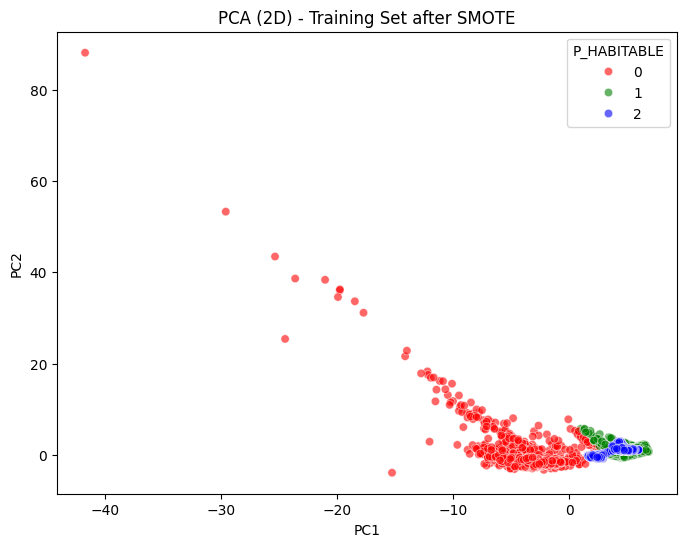

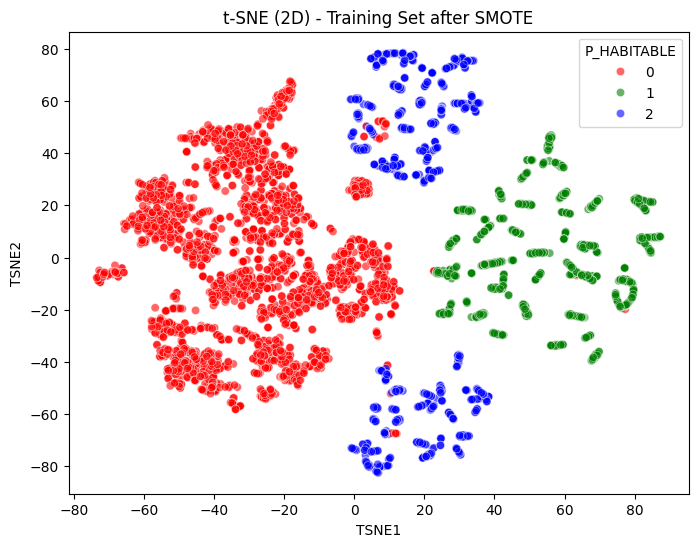

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

# -----------------------------
# Directory to save plots
# -----------------------------
SAVE_DIR = "./EDA_plots"
os.makedirs(SAVE_DIR, exist_ok=True)

# -----------------------------
# Controlled SMOTE (Multi-class)
# -----------------------------
class_counts = y_train.value_counts()

sampling_strategy = {
    1: int(class_counts[0] * 0.4),  # minority class 1
    2: int(class_counts[0] * 0.4)   # minority class 2
}

smote = SMOTE(
    sampling_strategy=sampling_strategy,
    random_state=42
)

X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", pd.Series(y_train_sm).value_counts())

# -----------------------------
# PCA (2D) Visualization
# -----------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_sm)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["P_HABITABLE"] = y_train_sm.values

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="P_HABITABLE",
    palette={0: "red", 1: "green", 2: "blue"},
    alpha=0.6
)
plt.title("PCA (2D) - Training Set after SMOTE")
plt.savefig(f"{SAVE_DIR}/pca_2d_smote.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# -----------------------------
# t-SNE (2D) Visualization
# -----------------------------
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42,
    init="pca"
)

X_tsne = tsne.fit_transform(X_train_sm)

tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["P_HABITABLE"] = y_train_sm.values

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=tsne_df,
    x="TSNE1",
    y="TSNE2",
    hue="P_HABITABLE",
    palette={0: "red", 1: "green", 2: "blue"},
    alpha=0.6
)
plt.title("t-SNE (2D) - Training Set after SMOTE")
plt.savefig(f"{SAVE_DIR}/tsne_2d_smote.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -----------------------------
# Identify numeric features
# -----------------------------
numeric_features = X_train.columns.tolist()

# -----------------------------
# Scaling Pipeline
# -----------------------------
scaler_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", scaler_pipeline, numeric_features)
    ],
    remainder="drop"
)

# -----------------------------
# Apply scaling (FIT ONLY ON TRAIN)
# -----------------------------
X_train_scaled = preprocessor.fit_transform(X_train_sm)
X_test_scaled = preprocessor.transform(X_test)

print("Scaling completed.")
print("Train shape:", X_train_scaled.shape)
print("Test shape:", X_test_scaled.shape)


Scaling completed.
Train shape: (5028, 14418)
Test shape: (1215, 14418)


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1199
           1       0.62      0.83      0.71         6
           2       0.60      0.60      0.60        10

    accuracy                           0.99      1215
   macro avg       0.74      0.81      0.77      1215
weighted avg       0.99      0.99      0.99      1215



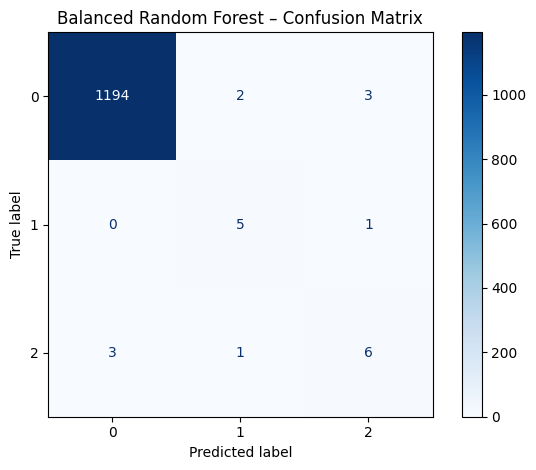

In [4]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# -----------------------------
# Initialize model
# -----------------------------
brf = BalancedRandomForestClassifier(
    n_estimators=300,
    random_state=42
)

# -----------------------------
# Train model
# -----------------------------
brf.fit(X_train_scaled, y_train_sm)

# -----------------------------
# Predict on test set
# -----------------------------
y_pred = brf.predict(X_test_scaled)

# -----------------------------
# Evaluation
# -----------------------------
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title("Balanced Random Forest – Confusion Matrix")
plt.tight_layout()
plt.savefig("./EDA_plots/balanced_rf_confusion_matrix.png", dpi=300)
plt.show()
plt.close()


In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt

# -----------------------------
# XGBoost on SMOTE data
# -----------------------------
xgb_model = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42,
    tree_method="hist"
)

# Train ONLY on SMOTE training data
xgb_model.fit(X_train_sm, y_train_sm)

# Predict on ORIGINAL test set
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)

# -----------------------------
# Metrics
# -----------------------------
print("XGBoost (SMOTE-trained)")
print(classification_report(y_test, y_pred_xgb))

roc_auc = roc_auc_score(
    y_test,
    y_prob_xgb,
    multi_class="ovr"
)
print(f"ROC-AUC (OvR): {roc_auc:.4f}")

# -----------------------------
# Confusion Matrix (PNG)
# -----------------------------
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title("XGBoost (SMOTE-trained) – Confusion Matrix")
plt.tight_layout()
plt.savefig("./EDA_plots/xgboost_smote_confusion_matrix.png", dpi=300)
plt.close()

XGBoost (SMOTE-trained)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1199
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00        10

    accuracy                           1.00      1215
   macro avg       1.00      1.00      1.00      1215
weighted avg       1.00      1.00      1.00      1215

ROC-AUC (OvR): 1.0000


In [ ]:
# =============================
# STEP 5: CLASS-WEIGHTED SVM
# =============================

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score
)
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Pipeline (Scaling REQUIRED)
# -----------------------------
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        class_weight="balanced",     # handles imbalance (0 >> 1 >> 2)
        probability=True,
        decision_function_shape="ovr",
        random_state=42
    ))
])

# -----------------------------
# Train
# -----------------------------
svm_pipeline.fit(X_train, y_train)

# -----------------------------
# Predictions
# -----------------------------
y_pred_svm = svm_pipeline.predict(X_test)
y_prob_svm = svm_pipeline.predict_proba(X_test)

# -----------------------------
# Metrics
# -----------------------------
print("Classification Report:\n")
print(classification_report(y_test, y_pred_svm))

roc_auc_svm = roc_auc_score(
    y_test,
    y_prob_svm,
    multi_class="ovr"
)

print(f"ROC-AUC (OvR): {roc_auc_svm:.4f}")

# -----------------------------
# Confusion Matrix (PNG ONLY)
# -----------------------------
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title("Class-Weighted SVM – Confusion Matrix")
plt.tight_layout()
plt.savefig("./EDA_plots/svm_confusion_matrix.png", dpi=300)
plt.close()

In [6]:
# =============================
# STEP 7: SAVE MODEL & PIPELINE
# =============================

import joblib
import os

os.makedirs("saved_models", exist_ok=True)

final_model = xgb_model 

joblib.dump(final_model, "saved_models/xgb_habitability_model.pkl")
joblib.dump(preprocessor, "saved_models/preprocessor.pkl")
joblib.dump(X.columns.tolist(), "saved_models/feature_columns.pkl")

print("✅ Model, preprocessor & feature list saved")


✅ Model, preprocessor & feature list saved


In [7]:
# =============================
# STEP 8: LOAD & TEST MODEL
# =============================

model = joblib.load("saved_models/xgb_habitability_model.pkl")
preprocessor = joblib.load("saved_models/preprocessor.pkl")
feature_columns = joblib.load("saved_models/feature_columns.pkl")

sample = X_test.iloc[[0]]
prediction = model.predict(sample)
prob = model.predict_proba(sample)

print("Prediction:", prediction)
print("Probabilities:", prob)


Prediction: [0]
Probabilities: [[9.9981636e-01 5.0830789e-05 1.3289166e-04]]
